<a href="https://colab.research.google.com/github/tayrone/tidy_tuesday_python/blob/main/fishing_210608.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_style("whitegrid")
#plt.rcParams['figure.figsize'] = [14, 4]

%load_ext google.colab.data_table
from google.colab import data_table as dt


In [2]:
fishing = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/'\
                      'tidytuesday/master/data/2021/2021-06-08/fishing.csv')

fishing = fishing[fishing.year > 1925]

## Exploratory Data Analysis

In [3]:
fishing_sum = (fishing
               .groupby(['year', 'lake'])[['values']]
               .sum())

No handles with labels found to put in legend.


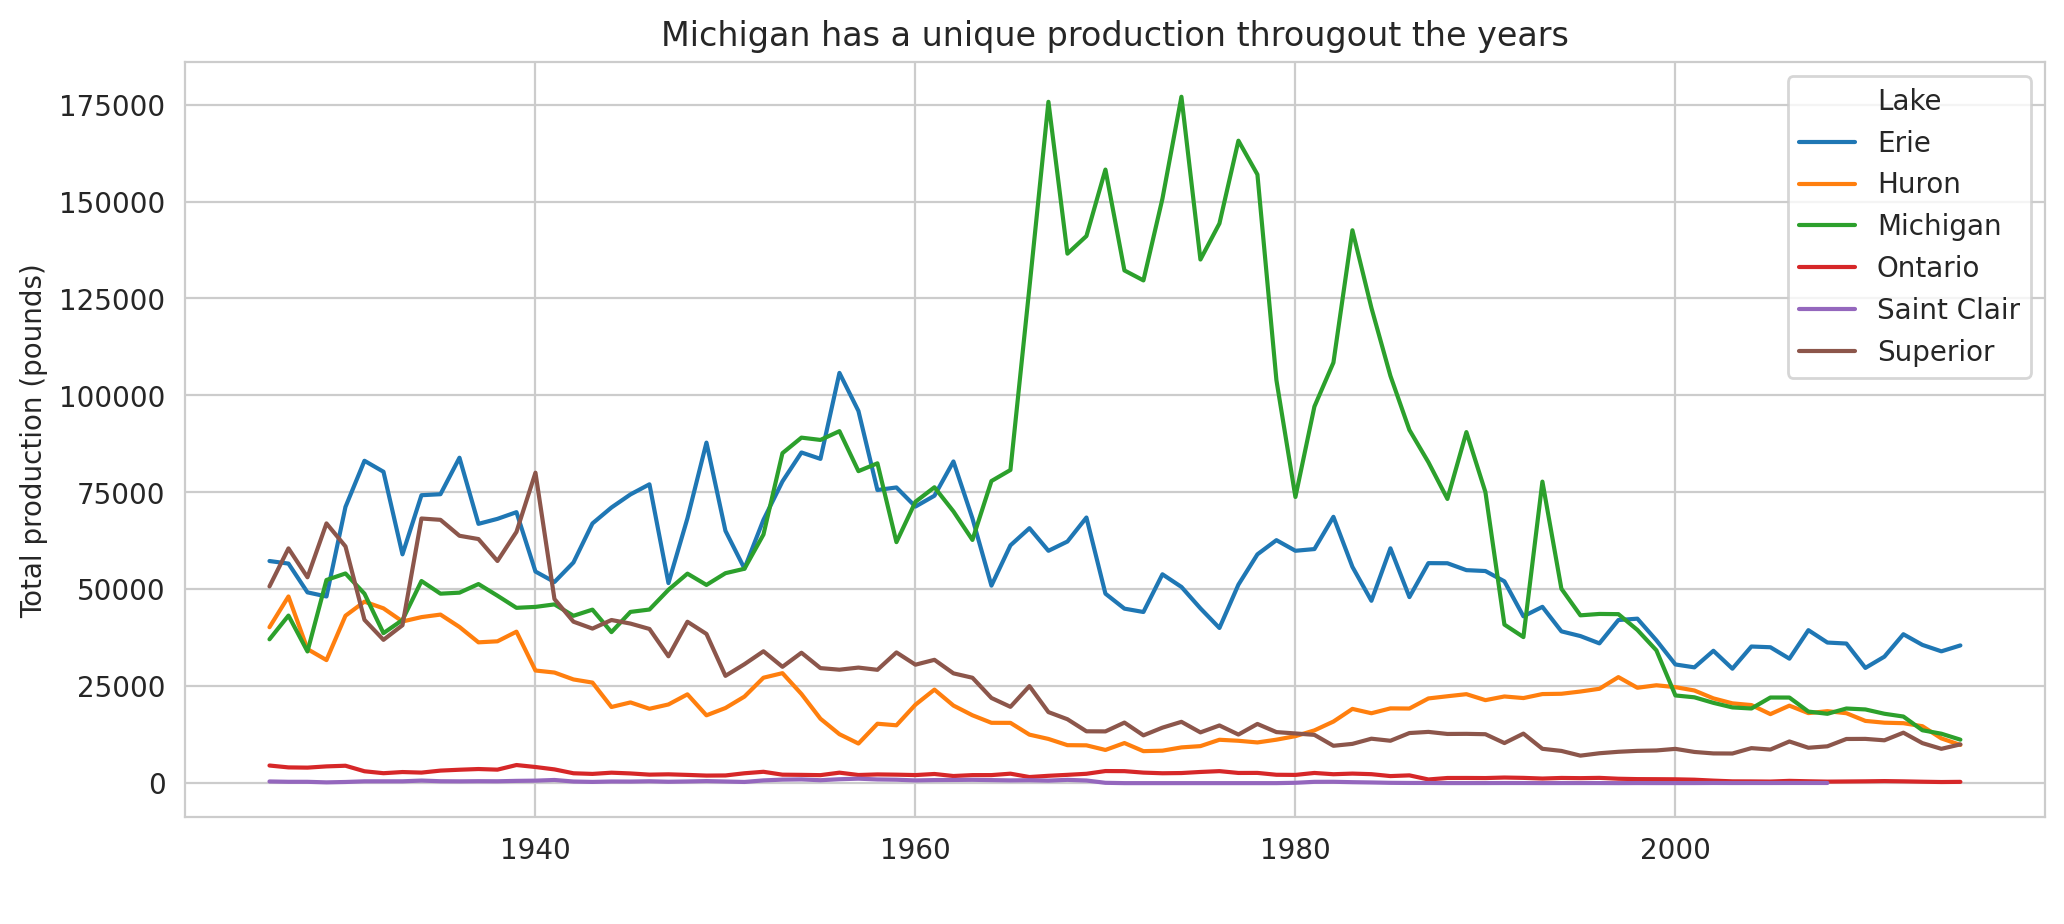

In [35]:
plt.figure(figsize = (12, 5), dpi = 200)
sns.set_style("whitegrid")

plt.ticklabel_format(style = 'sci', axis = 'y')
plt.title('Michigan has a unique production througout the years')
plt.ylabel('Total production (pounds)')
plt.xlabel(' ')
plt.legend(title = 'Lake')

# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax = sns.lineplot(x = 'year', y = 'values', data = fishing_sum, hue = 'lake',)

ax.legend(title = 'Lake')
plt.show(ax)


It is not feasible to analyze the behaviour of each species on each lake:

In [21]:
len(fishing
    .groupby(['year', 'lake', 'species'])
    .sum())

8682